In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing data

## Target

In [2]:
LOCAL_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/energy_generation_data/df_deutschland.csv'

def get_target_data(path=LOCAL_PATH, target='wind', hourly=False):
    if hourly:
        path = path.replace('daily/','hourly/')
    df = pd.read_csv(path, index_col='Date')
    df.index = pd.to_datetime(df.index)
    if hourly:
        df = df.resample('h').sum()    
    else:
        df = df.resample('d').sum()
    if target == 'wind':
        return df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
    if target == 'solar':
        return df['Photovoltaics[MWh]']

target_df = get_target_data(target='wind', hourly=True)


## Features

In [3]:
def get_best_station_ids(features_df, target_df):
    features_df['target'] = target_df
    corr_df = features_df.corr()
    best_stations = list(corr_df['target'][corr_df['target']>=0.6].index)[:-1]
    init_length = len(features_df.columns)
    final_length = len(best_stations)
    print(f'Droped {init_length - final_length} stations!')
    
    return best_stations

In [4]:
FEATURES_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/features'

def get_features_data(path=FEATURES_PATH, features=['wind'], optimized=True, grouped=True, hourly=False):
    if hourly:
        path = FEATURES_PATH.replace('/daily/features','/hourly/features/wind_hourly_clean.csv')
    else:
        path = f'{path}/winddailyofeverystation.csv'
    if 'wind' in features:
        wind_df = pd.read_csv(path, index_col='Date')
        wind_df.index = pd.to_datetime(wind_df.index)
        if optimized:
            best_stations = get_best_station_ids(wind_df, target_df)
            wind_df = wind_df[best_stations]
        if grouped:
            wind_df = wind_df.mean(axis=1)
    return wind_df
        
features_df = get_features_data(optimized=True, grouped=False, hourly=True)

Droped 139 stations!


##  Forecasted

In [ ]:
FORCASTED_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/forecasted_generation_data/df_deutschland_forecasted.csv'

def get_forcasted_data(path=FORCASTED_PATH, target='wind', hourly=False):
    if hourly:
        path = path.replace('/daily/', '/hourly/')
    df = pd.read_csv(path, index_col='Date')
    df.index = pd.to_datetime(df.index)
    if hourly:
        df = df.resample('h').sum()
    else:
        df = df.resample('d').sum()
    if target == 'wind':
        return df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
    if target == 'solar':
        return df['Photovoltaics[MWh]']

forcasted_df = get_forcasted_data(target='wind', hourly=False)
    

In [ ]:
#forecasted_df.loc[dt.date(2018,1,1):dt.date(2018,3,1)]

# Statistical exploration

## Train Test Split

In [86]:
def get_X_y(target_df, features_df, init_date=dt.datetime(2015,1,1), end_date=dt.datetime(2016,1,1)):
    '''return the the target and features data between the init_date and end_date time window'''
    X = features_df.loc[init_date:end_date]
    y = target_df.loc[init_date:end_date]
    return X, y

X, y = get_X_y(target_df, features_df, init_date=dt.date(2015,1,1), end_date=dt.date(2016,1,16))

In [87]:
def train_test_split(X, y, hours=24*2):
    index = len(X) - hours
    X_train = X.iloc[:index]
    X_test = X.iloc[index:]
    y_train = y.iloc[:index]
    y_test = y.iloc[index:]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, hours=24*15)

## Stationarity

### Visually

In [ ]:
y.hist(bins=50)

In [ ]:
plt.subplots(figsize=(12,8))
y.plot()

###  Calculations (mean, variance and autocorrelation)

In [89]:
def plot_autocorrelation(y, d=0, D=0, m=0):
    y = pd.Series(y)
    if D > 0:
        for i in range(D):
            y = y.diff(m)
    if d > 0:
        for i in range(d):
            y = y.diff(1)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,2,3)
    ax3 = fig.add_subplot(2,2,4)
    ax1.plot(y)
    plot_acf(y, lags = 50, ax=ax2);
    plot_pacf(y, lags=50, ax=ax3, color='r');
    plt.show()

In [90]:
y.mean()

8917.20469246793

In [91]:
# p-value (should be less than 0.05 to be sattionary)
adfuller(y_train)[1]

9.013654849711664e-12

In [92]:
y.var()

49983033.153820075

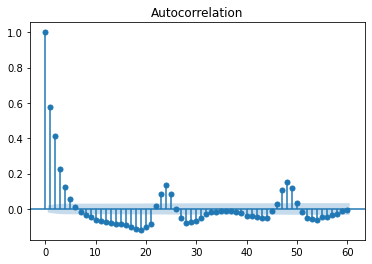

In [93]:
plot_acf(y.diff(1).dropna(), lags=60);

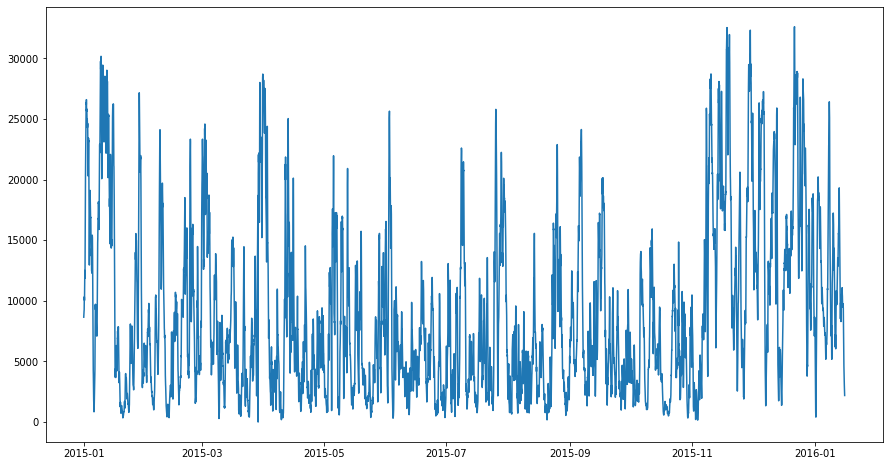

In [94]:
plt.subplots(figsize=(15,8))
plt.plot(y)

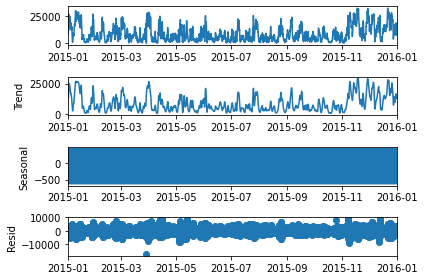

In [96]:
result_mul = seasonal_decompose(y_train, model='addictive')
result_mul.plot();

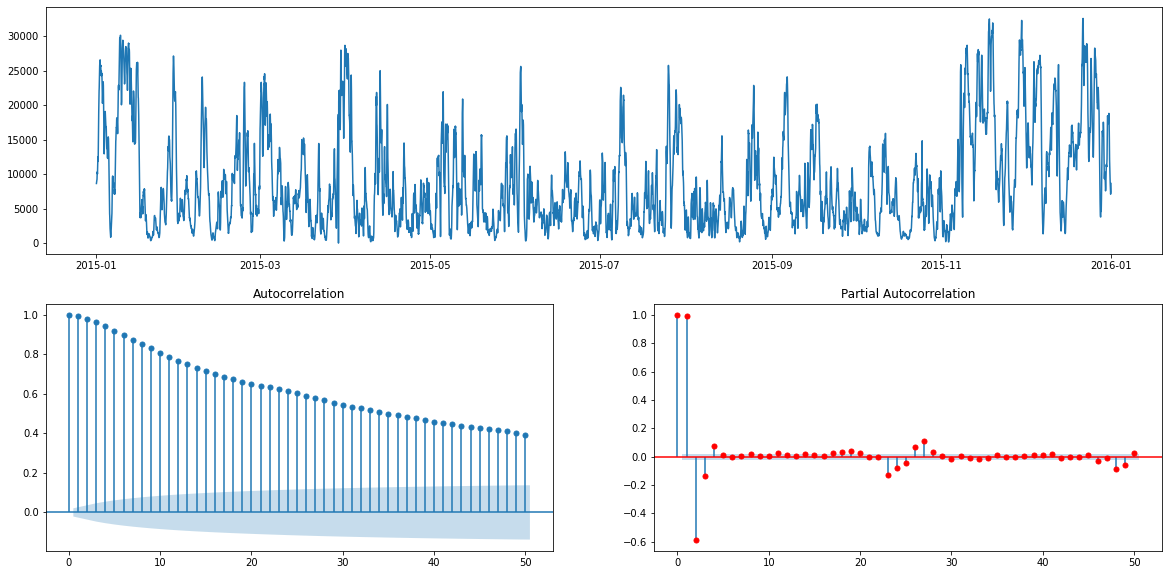

In [97]:
plot_autocorrelation(y_train, D=0, m=365*5)

In [45]:
import pmdarima as pm

smodel = pm.auto_arima(y_train, m=24, X=X_train.to_numpy().reshape(-1,1),
                       start_p=0, max_p=2,
                       start_q=0, max_q=5,
                       max_P=2, max_D=1,max_Q=2,
                       seasonal=True,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=28.97 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=139474.348, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=137252.820, Time=5.65 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=137818.589, Time=4.03 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=139472.351, Time=0.85 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=137507.178, Time=0.28 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=137081.803, Time=47.20 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=117.28 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=28.32 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=138456.178, Time=55.71 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=136891.947, Time=60.60 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=137095.532, Time=7.64 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=171.64 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=37.81 sec
 ARIMA(2,1,1)(2,

# Models

## ARIMA

In [28]:
# from statsmodels.tsa.arima_model import ARIMA

# arima = ARIMA(y_train, order=(1,1,2)).fit()
# arima.summary()

In [98]:
sarimax = SARIMAX(endog=y_train, exog=X_train, order=(2,1,0), seasonal_order=(2,0,0,24)).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


KeyboardInterrupt: 

In [ ]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [79]:
forecast = sarimax.forecast(len(y_test), exog=X_test, alpha=0.05)

In [80]:
X_test

,90,197,198,303,342,368,427,430,591,596,...,7396,7410,7416,13693,13901,13952,15000,15120,15189,15200
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 01:00:00,1.8,2.8,4.2,1.9,2.7,0.2,1.7,1.4,1.8,5.5,...,3.0,4.1,1.6,3.3,0.8,3.8,6.9,4.3,2.4,5.3
2016-01-01 02:00:00,1.9,3.3,4.0,2.1,2.8,0.3,1.7,1.6,2.6,5.2,...,3.0,3.8,0.9,3.5,0.7,4.4,7.4,4.7,1.4,4.9
2016-01-01 03:00:00,1.7,4.3,4.2,2.1,2.2,0.3,1.4,1.7,2.2,4.6,...,2.9,3.5,0.7,3.6,0.6,4.8,6.0,4.3,1.2,4.9
2016-01-01 04:00:00,1.7,5.1,3.5,1.8,2.7,0.1,1.9,0.9,2.1,4.4,...,2.5,3.0,0.9,3.6,0.8,5.0,6.1,4.2,1.7,4.8
2016-01-01 05:00:00,2.0,4.7,2.0,1.9,2.3,0.1,2.0,0.8,2.7,4.5,...,2.7,3.1,0.8,3.1,2.2,3.6,4.9,4.6,0.6,4.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-30 20:00:00,8.3,4.0,5.7,7.8,5.5,1.4,10.6,8.9,5.2,9.6,...,8.9,7.0,8.6,5.7,3.4,5.8,7.2,6.9,6.7,6.7
2016-01-30 21:00:00,8.0,5.3,5.8,5.8,5.2,1.9,9.2,9.5,4.7,8.2,...,9.6,9.0,7.8,6.5,4.1,5.7,6.4,7.6,7.9,6.7
2016-01-30 22:00:00,6.0,5.1,7.1,7.1,5.9,2.2,8.7,5.6,5.1,9.2,...,9.2,7.4,9.3,5.9,4.2,5.6,6.6,7.4,6.6,6.2


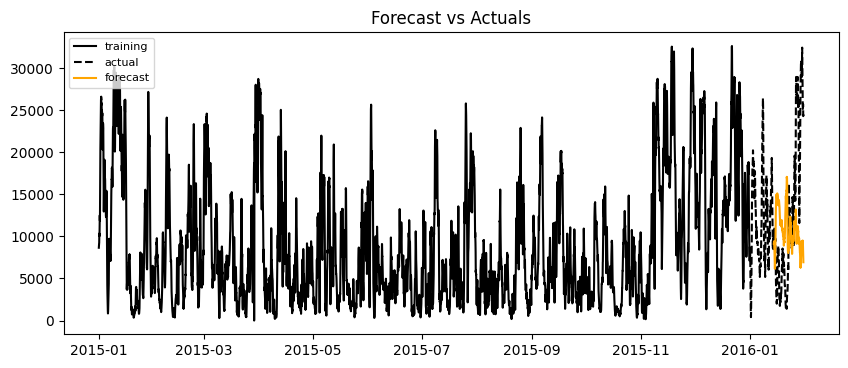

In [78]:
plot_forecast(forecast, y_train, y_test)

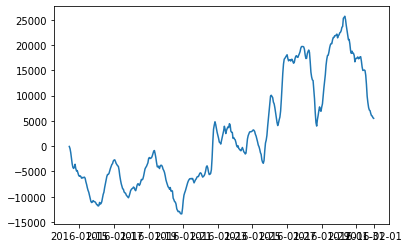

In [64]:
residuals = y_test - forecast
plt.plot(residuals)

In [47]:
sarimax.mae

341.5164098892043

In [27]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
mae(y_test, forecast)

855.0057136525116

In [29]:
sarimax.mse

338419.50024605816

In [30]:
mse(y_test, forecast)

1105876.347769246

In [32]:
mean_absolute_percentage_error(y_test, forecast)

8.52754434601609

In [34]:
# asbolute values MAPE
baseline = mean_absolute_percentage_error(y_test, forecast)
baseline

8.52754434601609

In [35]:
# log values MAPE
log_baseline = mean_absolute_percentage_error(np.log(y_test), np.log(forecast))
log_baseline

0.8707221647966732

In [67]:
# SMARD forcast MAPE
mean_absolute_percentage_error(y_test, forcasted_df.loc[dt.date(2016,1,1):dt.date(2016,3,31)])

NameError: name 'forcasted_df' is not defined

In [ ]:
# SMARD log forcast MAPE
THE_BAR = mean_absolute_percentage_error(y_test, np.log(mini_forecast))
THE_BAR